# Скрининговая диагностика

[Данные по маммографии](https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass) - один из общедоступных наборов данных в архиве Центра машинного обучения.
Собран в Институте Радиологии университета Эрланген-Нюрнберг, Erlangen, Germany в период между 2003 и 2006 гг
{cite}`elter2007`.

Маммография является наиболее эффективным методом скрининга рака молочной железы, доступных сегодня.
Однако низкая положительная прогностическая ценность биопсии молочной железы в результате интерпретации маммографии приводит к примерно 70% ненужных биопсий с доброкачественными результатами.
Для снижения количества ненужных биопсий молочных желез предлагаются системы автоматизированной диагностики, которые помогают врачу решить: делать биопсию подозрительного участка или пока отложить инвазивную проверку и понаблюдать.


Колонки:

1. Оценка BI-RADS в диапазоне от 1 (определенно доброкачественная)
   до 5 (очень подозрительно злокачественная), полученная в процессе двойного осмотра врачами. (порядковый)
2. Возраст пациента в годах
3. Форма образования: round=1 oval=2 lobular=3 irregular=4 
4. Край образования: очерченный = 1 мелкодольчатый = 2 расплывчатый = 3 плохо определенный = 4 пальчатый = 5
5. Плотность образования: высокая = 1 изо = 2 низкая = 3 жиросодержащая = 4 (порядковый)
6. Реальная тяжесть: доброкачественная = 0 или злокачественная = 1 (биноминальный)



In [1]:
%pylab inline
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
#https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data
kk = 'est age forma krai dens itog'.split()
D = pd.read_csv('d/mammographic_masses.data', names=kk, header=None, na_values='?')
D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   est     959 non-null    float64
 1   age     956 non-null    float64
 2   forma   930 non-null    float64
 3   krai    913 non-null    float64
 4   dens    885 non-null    float64
 5   itog    961 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.2 KB


> Создайте ячейку и, выполнив код `D`, посмотрите содержимое таблицы. Возьмите одну строчку и объясните ситуацию у данного пациента.

In [3]:
# D.loc[562]

Посмотрим распределение всех четырех объясняющих показателей.
При этом настроим палитру, чтобы плохой исход был пугающе красным, а хороший - успокаивающе зеленым. (n=2)

In [4]:
#pal = sns.choose_diverging_palette()
pal = sns.diverging_palette(120, 350, n=2, sep=10)
sns.color_palette(pal)

[(0.310841115279521, 0.516974408539226, 0.221301273388138),
 (0.8157621607216431, 0.24428033418979656, 0.49767963166159107)]

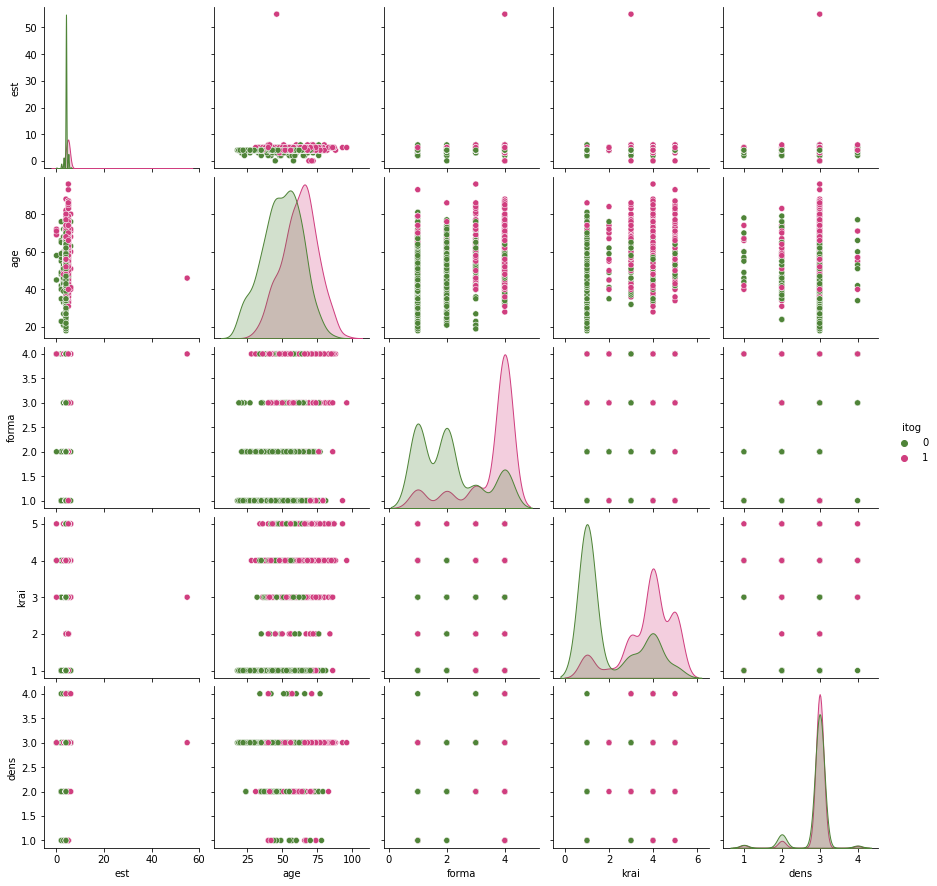

In [5]:
sns.pairplot(data=D, x_vars=D.columns[:-1], y_vars=D.columns[:-1], dropna=False,
    hue="itog", 
    diag_kind="kde", 
    palette=pal);

Видны расхождения по многим признакам, а значит можно настроить прогностическую модель, которая будет предсказывать итог.

Авторами заявлено, что оценка врачей `est` варьирует от 1 до 5. Одно значение 55. Это явно опечатка.

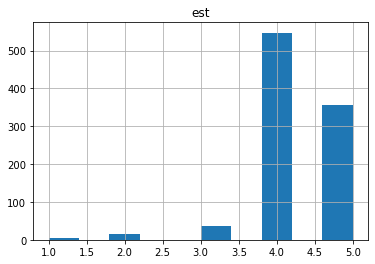

In [6]:
D.loc[D.est>5,'est']=5
D.loc[D.est<1,'est']=1
D.hist('est');

Могли ли врачи предсказать итоги биопсии?

In [7]:
(
    D.est.corr(D.itog),
    D.est.corr(D.itog, 'kendall'),
    D.est.corr(D.itog, 'spearman')
)

(0.5360230051347603, 0.6061147157824877, 0.6213620971586996)

Оценки врачей коррелировали с итоговыми данными биопсии.

## Зависимость от возраста

Чем старше возраст пациентки, тем больше вероятность того, что образование злокачественное.

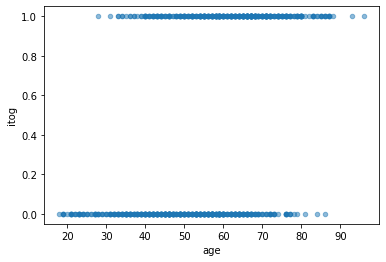

In [8]:
D.plot('age','itog', kind='scatter', alpha=.5);

Диапазоны значительно перекрываются и, например, нельзя одназначно сказать о качестве новообразований у женщин в возрасте 50 лет. Поскольку исходов всего два, то можно говорить о вероятности.

Давайте преобразуем данные в вероятности - доли одного исхода события от общего количества событий.

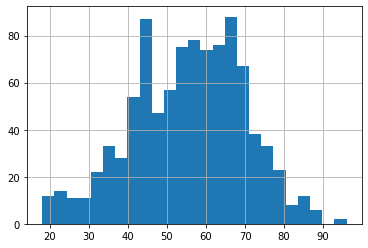

In [9]:
D.age.hist(bins=25);

Следует отметить, что сходство распределения по возрасту с нормальным распределением говорит не о законе распределения признака (как известно возраст начинается с 0), а лишь о том, в каком возрасте у женщин встречаются образования в грудных железах.

Давайте поделим весь диапазон на пятилетки и посчитаем процент злокачественности.

In [10]:
agegroup = np.arange(15,105,5)
D['agegroup'] = pd.cut(D.age, agegroup)

D.groupby(['agegroup']).itog.count()

agegroup
(15, 20]       6
(20, 25]      23
(25, 30]      19
(30, 35]      44
(35, 40]      58
(40, 45]      94
(45, 50]      96
(50, 55]     111
(55, 60]     139
(60, 65]     114
(65, 70]     108
(70, 75]      67
(75, 80]      49
(80, 85]      15
(85, 90]      11
(90, 95]       1
(95, 100]      1
Name: itog, dtype: int64

Самыми многочисленными оказались возрастные группы от 50 до 70 лет. 

Наша задача сгруппировать по двум колонкам и посчитать количество случаев принадлежности к группам в одной и другой колонках.

In [11]:
G = D.groupby(['agegroup','itog']).itog.count().unstack()
G

itog,0,1
agegroup,,
"(15, 20]",6,0
"(20, 25]",23,0
"(25, 30]",18,1
"(30, 35]",38,6
"(35, 40]",44,14
"(40, 45]",66,28
"(45, 50]",65,31
"(50, 55]",64,47
"(55, 60]",77,62


Заменим отсутствующие значения и подсчитаем общее количество.

In [12]:
G = G.fillna(0).astype(int)
G = G.rename(columns={0:'dobro', 1:'zlo'})

G['N'] = G.dobro + G.zlo
G

itog,dobro,zlo,N
agegroup,,,
"(15, 20]",6,0,6
"(20, 25]",23,0,23
"(25, 30]",18,1,19
"(30, 35]",38,6,44
"(35, 40]",44,14,58
"(40, 45]",66,28,94
"(45, 50]",65,31,96
"(50, 55]",64,47,111
"(55, 60]",77,62,139


Считаем вероятность...

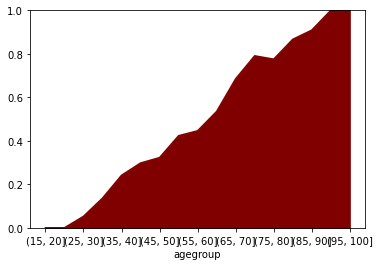

In [13]:
G['p'] = G.zlo/G.N

G.p.plot(kind='area', color='maroon', ylim=(0,1));

Похоже на линейную зависимость вероятности от возраста. Но линейный тренд будет продолжаться вверх и вниз, а вероятность не может быть 120% в возрасте 110 лет или -10% в возрасте 10 лет.
Адекватная модель должна попадать только в диапазон [0, 1].

Нам подходит [логистическая модель](https://en.wikipedia.org/wiki/Logistic_function), описывающая переход от 1 к 0 или обратно.


$$y(x) = { 1 \over 1+e^{-k(x-x_0)} }$$

In [14]:
import scipy.optimize as optimize

In [271]:
def func(x, x0, k):
#     '''https://en.wikipedia.org/wiki/Logistic_function'''
        return 1 / (1 + np.exp(k*(x-x0)))

# Чтобы попасть в середину пятилетних диапазонов, то к нижним границам 
# надо прибавить половину диапазона - 2.5 года.
x = agegroup[:-1]  + 2.5
y = G.p.values
# добавим полочки, чтобы подбор модели был надежным
yopt = r_[[0,0,0], y, [1,1,1]]
xopt = np.arange(0,115,5) + 2.5

popt, pcov = optimize.curve_fit(func, xopt, yopt, 
#                                 bounds=([20, -1], [90, 0]),
                                p0=[55, 0])
popt

array([57.68166044, -0.0779198 ])

Чтобы оценить подгонку модели, наложим полученную кривую на исходные значения вероятности.

Для оценки надежности эмпирической вероятности можно посчитать доверительный интервал, но алгоритм для этого должен быть особый - ведь границы интервала не должны выходить за пределы диапазона [0...1].

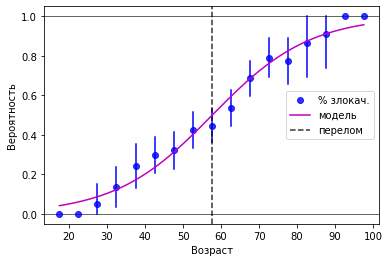

In [299]:
from statsmodels.stats.proportion import proportion_confint
lower, upper = proportion_confint(G.zlo, G.N, 0.05)

co='b'

plot(x, y, marker='o', lw=0, color=co, alpha=.8, zorder=3, label='% злокач.')
# добавим доверительные интервалы
plot(np.tile(x, (2,1)), c_[lower, upper].T, co)

xx = linspace(x.min(), x.max(), 200)
yy = func(xx, *popt)
plot(xx, yy, color='m', ls='-', zorder=10, label='модель');

axvline(popt[0], color='k', ls='--', alpha=.8, label='перелом')

axhline(0, color='k', ls='-', lw=1, alpha=.6)
axhline(1, color='k', ls='-', lw=1, alpha=.6)

xlabel('Возраст');
ylabel('Вероятность')
legend();

Вывод. После 58 лет преобладает вероятность злокачественного исхода новообразований в груди.

Мы использовали огрубленные данные, поскольку считали вероятности с шагом в 5 лет.
А что, если попробовать подобрать логистическую модель к исходным данным без подсчета вероятности?

In [17]:
D_ = D[D.age.notnull()] #отберем только с указанием возраста
x = D_.age
y = D_.itog

# зададим в качестве начальных значений полученные ранее
popt, pcov = optimize.curve_fit(func, x, y, p0=[50, -0.07])
popt

array([58.52211327, -0.07062092])

Стандартную ошибку получаем как корень квадратный из вариаций, которые идут по диагонали ковариационной матрицы.

In [18]:
perr = np.sqrt(np.diag(pcov))
perr

array([0.98835055, 0.00662141])

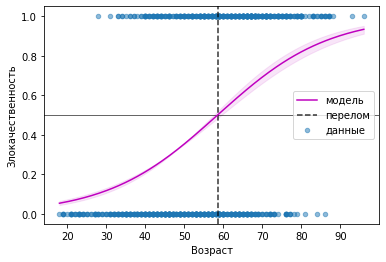

In [19]:
D.plot('age','itog', kind='scatter', alpha=.5, label='данные');

xx = linspace(x.min(), x.max(), 200)
yy = func(xx, *popt)
plot(xx,yy, color='m', ls='-', zorder=10, label='модель');

yymax = func(xx, *(popt+perr))
yymin = func(xx, *(popt-perr))
fill_between(xx, yymin, yymax, alpha=0.1, color='m')

axvline(popt[0], color='k', ls='--', alpha=.8, label='перелом')
axhline(0.5, color='k', ls='-', lw=1, alpha=.6)

xlabel('Возраст');
ylabel('Злокачественность')
legend();

Вывод. 
Параметры логистической модели можно получить на выборке бинарных данных: из 0 и 1. 

После 58.5 лет преобладает вероятность злокачественного исхода новообразований в груди.